In [175]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from IPython.display import display, Markdown
from plotly.subplots import make_subplots
import textwrap
import os

# BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import openai
from bertopic.representation import OpenAI
from sklearn.metrics.pairwise import cosine_similarity


## **TABLE OF CONTENTS**:
- [DATASET](#dataset)
- [HOW TO USE](#how_to_use)
- [SEARCH DATASET](#search-dataset)
- [PARAMETERS BERTopic](#parameters)
- [LOAD DATA](#load-data)
- [EXECUTE BERT](#execute-bert)
- [ANALYZE CLUSTERS](#analyze-clusters)
  - [TOPIC BARCHART](#topic_barchart)
  - [TOPIC HIERARCHY](#topic_hierarchy)
  - [TOPIC DISTANCE MAP](#topic_distance)
- [MERGE CLUSTERS INTO DATASET](#merge_clusters)
- [TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER](#query_assign)
  - [ASSIGNED TOPICS WORDCLOUD](#topic_worldcloud)
- [VIZUALIZATIONS FOR ONE SPECIFIC TOPIC](#visual_one)
  - [PROJECTS IN TOPIC](#projects_topic)
  - [RELATED TOPICS](#topic_related)
- [VIZUALIZATIONS FOR MULTIPLE TOPICS](#visual_multiple)
  - [PROJECT COUNT OVER TIME](#project_count)
  - [FUNDING SCHEMES](#funding)
  - [DEPARTMENTS](#departments)
  - [SUB-DEPARTMENTS](#sub_departments)
  - [FUNDING SCHEMES IN DEPTH](#funding_depth)
- [COMPARING TWO TOPICS](#compare)
- [DEEP DIVE INTO TOPIC](#deep_dive)
- [SOURCES](#sources)

## **HOW TO USE** <a class="anchor" id="how_to_use"></a>
1. Select dataset, it should be cleaned with the provided code in the data_preprocessing folder.
2. Input a query, from your query topics will be assigned. Similarity will be calculated between your query and each topic representation, from this the top $n$ topics will be selected.
3. Set parametes for BERTopic. Note: some visualizations have also paramters, those can be changed at the specific visualizations. To easily find these parameters, they will be marked with <font color='red'>**PARAMETER**</font>.
4. Run the whole notebook.
5. Use table of contents to get desired info. Note: Some visualizations allow you to change the topics you want to visualize, where this can be done will be marked with <font color='red'>**SELECT**</font><br>


## **DATASET** <a class="anchor" id="dataset"></a>

In [176]:
DATASET = "../data/df_projects_merged.pkl" # dataset name / location
EXPORT_TOPICS = False # set to true if you want to export all topics
DF_TOPICS = "df_topics_info.csv" # set name for exported topics data (must be .csv)
EXPORT_TOPICS_MERGED = False # set to true if you want to export dataset with topics
DF_TOPICS_MERGED = "df_projects_merged_topics.csv" # set name for exported dataset with topics (must be .csv)

## **SEARCH DATASET** <a class="anchor" id="search-dataset"></a>

In [177]:
# input your project query here, e.g. roman empire alexander the great greece
QUERY = ['sustainability industry innovation process technology innovation raw materials circularity consumption goods']

## **PARAMETERS BERTopic** <a class="anchor" id="parameters"></a>

Here are the parameters for BERTopic. We set them to the values that we believe are best.

In [178]:
# the model
LOAD_EMBEDDINGS = True  # set to True if embeddings are pre-saved
LOAD_MODEL = True  # set to True if a model is pre-saved
# the number of words per topic that you want to be extracted. These words are most representative of the topic.
N_WORDS_REPRESENTATION = 8
# the number of words you want in your topic representation. If you want 'Circular Economy' in your representations, set it to (1,2)
N_GRAM_RANGE = (1, 2)
# the minimum size of a topic. Lower means more topics, higher means less topics.
MIN_TOPIC_SIZE = 8

# assigning topics
TOPIC_COUNT = 8  # number of topics to identify; higher values will reduce accuracy
MIN_PROJECTS_CLUSTER = 0 # set higher to filter out topics with few projects

## **LOAD DATA** <a class="anchor" id="load-data"></a>

In [179]:
df_projects = pd.read_pickle(DATASET)

In [180]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # None means all data will be displayed in one line
pd.set_option('display.max_colwidth', 50)  # None means all data will be displayed without truncation

print(df_projects.shape)
display(df_projects.head(2))

(27668, 9)


,project_source,display_name,project_id,funding,start_date,title,summary,text,cost
0,nwo_api_2024_06_03,NWO,612.001.210,2691,2014-01-01,enhancing efficiency and expressiveness of the...,coalgebraic coinduction generalises the bisimu...,enhancing efficiency and expressiveness of the...,NaN
1,nwo_api_2024_06_03,NWO,12859,231,2014-01-01,modular selfassembling fluorescent nanoparticl...,there is a need for novel nanoparticles for di...,modular selfassembling fluorescent nanoparticl...,NaN


## **EXECUTE BERT** <a class="anchor" id="execute-bert"></a>

In [181]:
# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""

client = openai.OpenAI()
openai_model = OpenAI(client, model="gpt-3.5-turbo-0125", exponential_backoff=True, chat=True, prompt=prompt)

representation_model = {
    "OpenAI": openai_model
}

In [182]:
docs = list(df_projects.text.values) # create stacked list of abstracts

if LOAD_EMBEDDINGS:
    # load embeddings
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = np.load('embeddings/combined_data_sources/embeddings.npy')
else:
    # pre-embed abstracts
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=True)
    
    # Ensure the directory exists
    save_dir = 'embeddings/combined_data_sources/'
    os.makedirs(save_dir, exist_ok=True)
    
    # save embeddings
    np.save(os.path.join(save_dir, 'embeddings.npy'), embeddings)

In [183]:
if LOAD_MODEL:
    # load the BERTopic model
    topic_model = BERTopic.load("models/combined_data_sources/BERTopic")

    # use the transform method to obtain topics and probabilities for the new documents
    topics, probs = topic_model.transform(docs, embeddings)
else:
    vectorizer_model = CountVectorizer(stop_words="english")
    
    topic_model = BERTopic(verbose=True, 
                        calculate_probabilities=True,
                        top_n_words=N_WORDS_REPRESENTATION,
                        n_gram_range=N_GRAM_RANGE,
                        min_topic_size=MIN_TOPIC_SIZE,
                        vectorizer_model=vectorizer_model,
                        representation_model=representation_model,
                        embedding_model=sentence_model)

    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    # Ensure the directory exists
    save_dir = 'models/combined_data_sources/'
    os.makedirs(save_dir, exist_ok=True)

    # save the model
    embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
    topic_model.save(os.path.join(save_dir, "BERTopic"), serialization="safetensors", save_embedding_model=embedding_model)

2024-06-20 15:43:33,449 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [184]:
# add chatgpt labels to the model
chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "Outlier Topic"
topic_model.set_topic_labels(chatgpt_topic_labels)

topic_model.get_topic_info().head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,11324,-1_research_project_new_development,Outlier Topic,"[research, project, new, development, data, us...",[Innovative Data-Driven Scientific Projects],NaN
1,0,445,0_innovation_rri_smes_ri,Innovation Support for European SMEs,"[innovation, rri, smes, ri, european, research...",[Innovation Support for European SMEs],NaN


## **ANALYZE CLUSTERS** <a class="anchor" id="analyze-clusters"></a>

In [185]:
# show most prominent topics
df_topic_info = topic_model.get_topic_info()
df_topic_info.head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,11324,-1_research_project_new_development,Outlier Topic,"[research, project, new, development, data, us...",[Innovative Data-Driven Scientific Projects],NaN
1,0,445,0_innovation_rri_smes_ri,Innovation Support for European SMEs,"[innovation, rri, smes, ri, european, research...",[Innovation Support for European SMEs],NaN


In [186]:
if EXPORT_TOPICS is True:
    df_topic_info.to_csv(DF_TOPICS, index=False)

**Topic -1 are outliers**

#### **TOPIC BARCHART** <a class="anchor" id="topic_barchart"></a>

In [187]:
topic_model.visualize_barchart(top_n_topics=8, n_words=20, custom_labels=True, width=400)

#### **TOPIC HIERARCHY** <a class="anchor" id="topic_hierarchy"></a>

This plot shows the cluster hierarchy. Since we use HDBSCAN as a clustering algorthim, this means that clusters within clusters can be formed, to understand how these are related to each other we can use the plot below. A color indicates clusters that are closer related to each other. These are then broken down to smaller clusters with more specific topics.

In [188]:
# topic_model.visualize_hierarchy(custom_labels=True)

#### **TOPIC DISTANCE MAP** <a class="anchor" id="topic_distance"></a>

This graph shows the 2D representation of the clusters, where the y-axis is the first dimensionality and the x-axis the second dimensionality.

Use the slider to select a topic, which will then light up. Hovering over a topic will give the topic size and its label. If you hold and drag with your mouse pointer you can zoom into the map to analyze the cluster structure.

In [189]:
topic_model.visualize_topics(custom_labels=True)

## **MERGE CLUSTERS INTO DATASET** <a class="anchor" id="merge_clusters"></a>

In [190]:
df_projects = pd.read_pickle(DATASET)
df_projects = df_projects.copy()

In [191]:
df_projects['Topic'] = topics
df_projects.head(1)

,project_source,display_name,project_id,funding,start_date,title,summary,text,cost,Topic
0,nwo_api_2024_06_03,NWO,612.001.210,2691,2014-01-01,enhancing efficiency and expressiveness of the...,coalgebraic coinduction generalises the bisimu...,enhancing efficiency and expressiveness of the...,NaN,267


In [192]:
df_projects['Topic'] = df_projects['Topic'].astype(int)

df_projects = pd.merge(df_projects, df_topic_info[['Topic', 'Representation', 'CustomName']], left_on='Topic', right_on='Topic', how='left')

In [193]:
df_projects.head(1)

,project_source,display_name,project_id,funding,start_date,title,summary,text,cost,Topic,Representation,CustomName
0,nwo_api_2024_06_03,NWO,612.001.210,2691,2014-01-01,enhancing efficiency and expressiveness of the...,coalgebraic coinduction generalises the bisimu...,enhancing efficiency and expressiveness of the...,NaN,267,"[modal, automata, logics, fixpoint, logic, pro...",Modal Fixpoint Logic Study


In [194]:
if EXPORT_TOPICS_MERGED is True:
    df_projects.to_csv(DF_TOPICS_MERGED, index=False)

In [195]:
def print_markdown(md_string):
    display(Markdown(md_string))
    
def print_markdown_list(items):
    md_string = ""
    for item in items:
        md_string += f"- ##### {item}\n"
    display(Markdown(md_string))

## **TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER** <a class="anchor" id="query_assign"></a>

These are the topics related to your query. Your query is firstly embedded, and then used to calculate the cosine similarity with each topic representation. The top $n$ topics are then shown. The number of topics shown can be changed at the top of the notebook.

In [196]:
print_markdown(f"### Input query:\n##### {QUERY[0]}")

similar_topics, similarity = topic_model.find_topics(QUERY[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics}\n")
TOPICS = [topic for topic in similar_topics if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]

print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Input query:
##### sustainability industry innovation process technology innovation raw materials circularity consumption goods

### Topics found (numbers):
##### [53, 367, 6, 71, 210, 290, 296, 88]


### Topics, ranked top to bottom, match with query:


- ##### (53): Circular Economy Transition Model
- ##### (367): Circular Material Reuse Solutions
- ##### (6): Plastic Recycling Innovations
- ##### (71): Circular Textile Innovation
- ##### (210): Rubber Recycling Innovations
- ##### (290): Sustainable Rare Earth Magnet Recycling
- ##### (296): Sustainable Urban Waste Management
- ##### (88): Circular Composite Material Reuse


#### **ASSIGNED TOPICS WORDCLOUD** <a class="anchor" id="topic_worldcloud"></a>

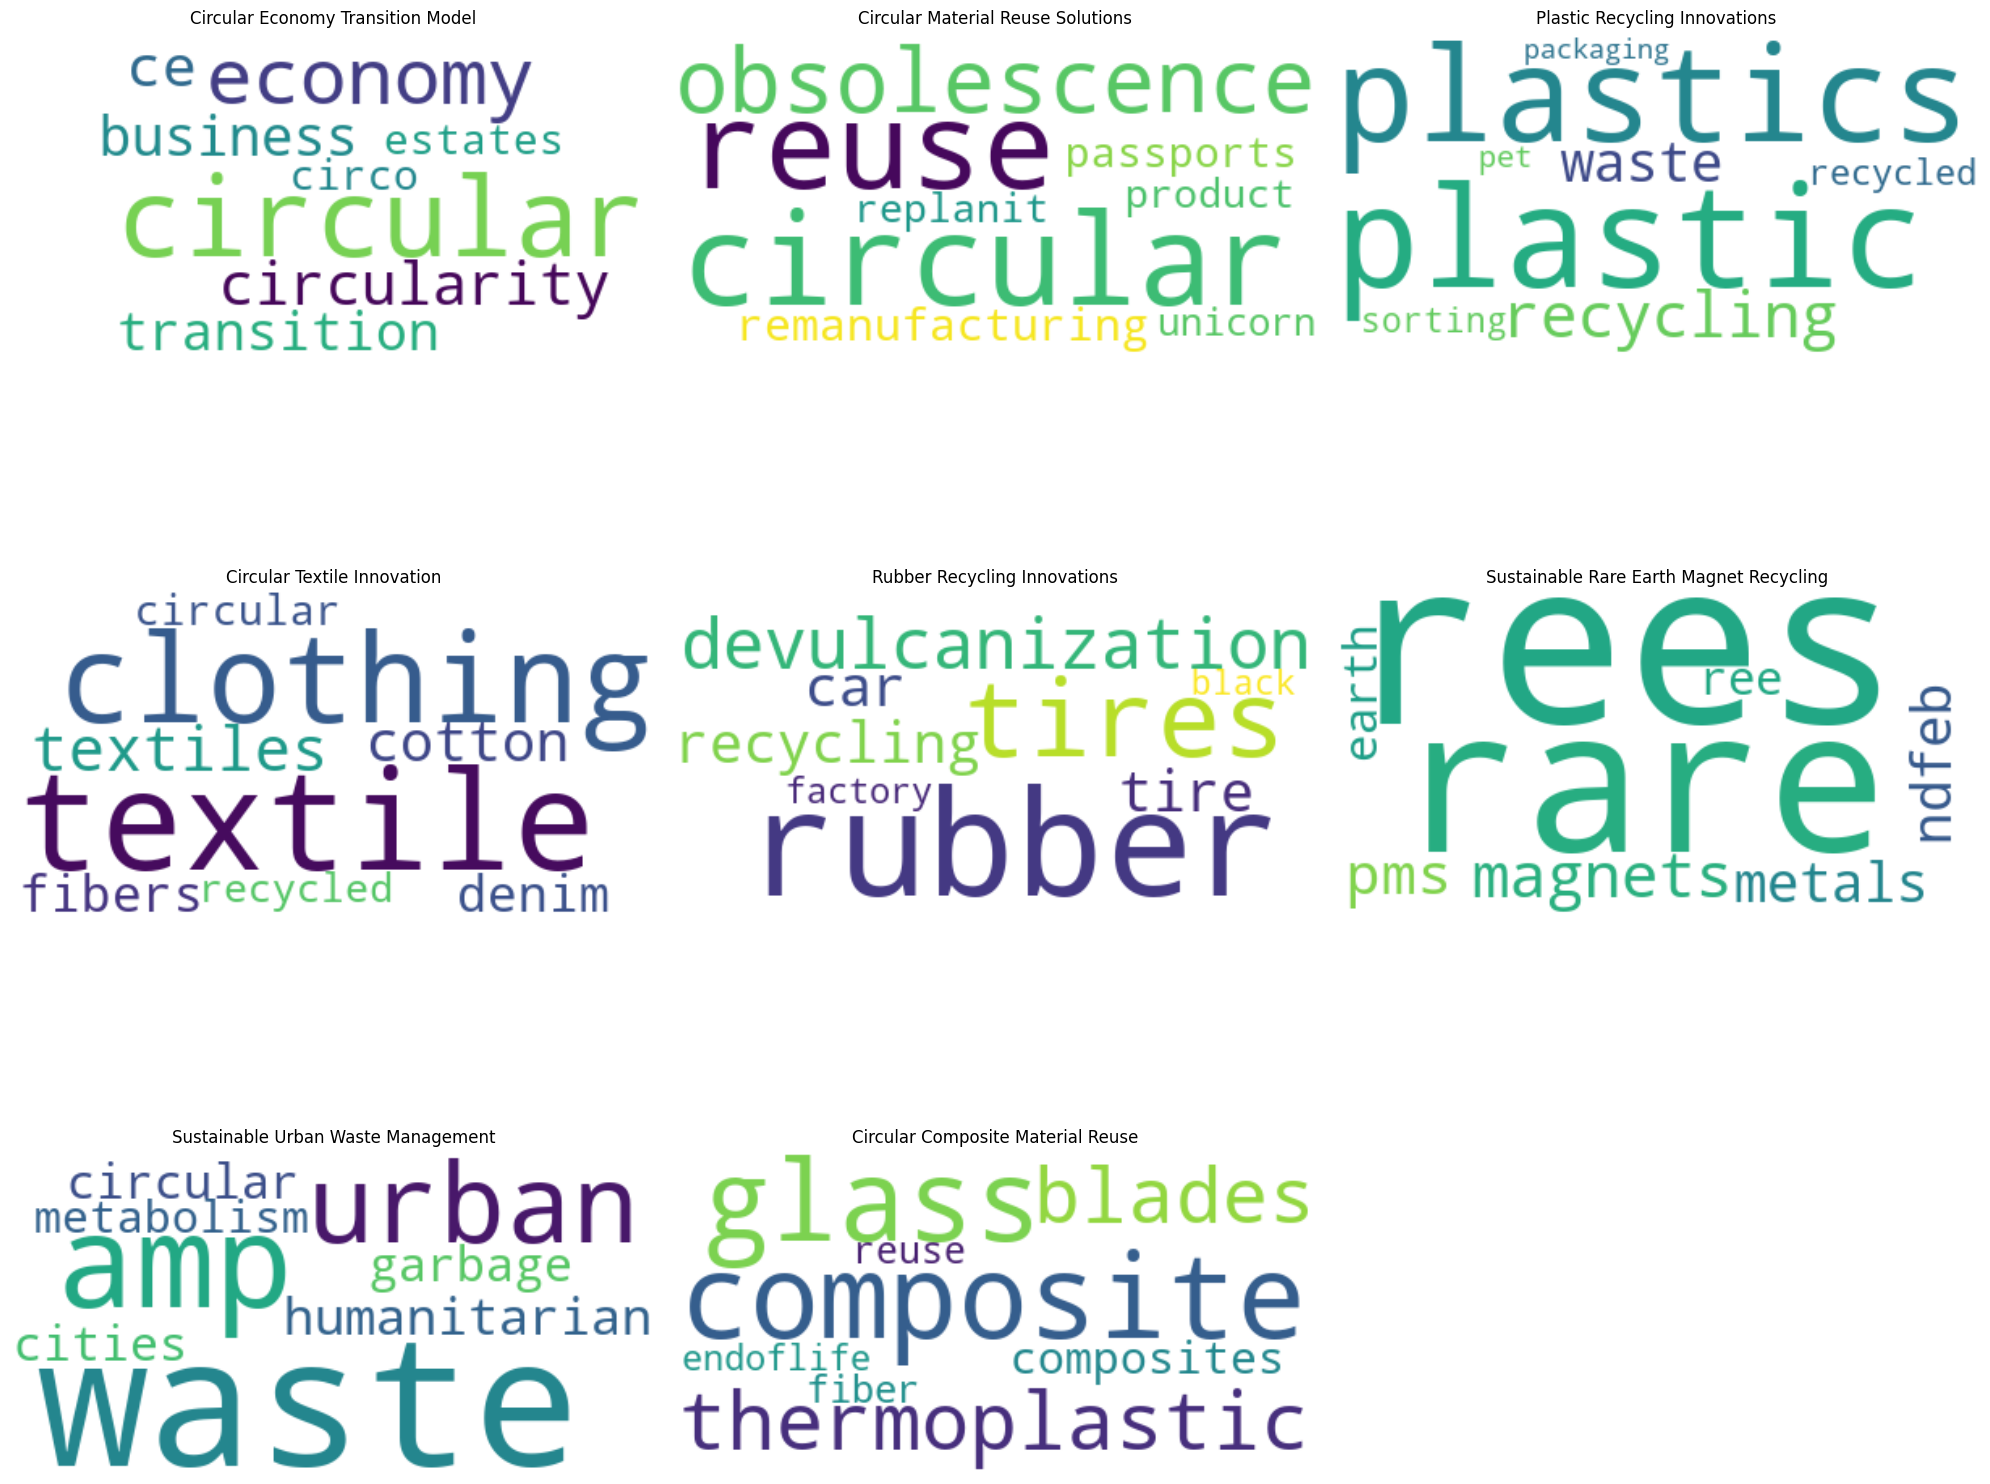

In [197]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    return wc.generate_from_frequencies(text)

# generate and plot each word cloud
cols = 3  # maximum three plots per row
rows = (len(TOPICS) + cols - 1) // cols  # calculate the number of rows needed
plt.figure(figsize=(20, 6 * rows))  # adjust figure size as needed

for index, topic in enumerate(TOPICS):
    plt.subplot(rows, cols, index + 1)  # create a subplot for each topic
    wc = create_wordcloud(topic_model, topic=topic)
    
    # retrieve the custom name for the topic
    topic_projects = df_projects[df_projects['Topic'] == topic]
    if not topic_projects.empty:
        title = topic_projects['CustomName'].iloc[0]
    else:
        title = f"Topic {topic}"
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

## **VIZUALIZATIONS FOR ONE SPECIFIC TOPIC** <a class="anchor" id="visual_one"></a>

How to use: Choose a single topic you want to visualize, pick one number from the topics that where assigned to your query. By default this will be the topic that best matched your query. The topics found are listed here again below:

In [198]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (53): Circular Economy Transition Model
- ##### (367): Circular Material Reuse Solutions
- ##### (6): Plastic Recycling Innovations
- ##### (71): Circular Textile Innovation
- ##### (210): Rubber Recycling Innovations
- ##### (290): Sustainable Rare Earth Magnet Recycling
- ##### (296): Sustainable Urban Waste Management
- ##### (88): Circular Composite Material Reuse


##### <font color='red'>**SELECT**</font><br>

In [199]:
SELECTED_TOPIC_ID = TOPICS[0] # choose topic for visualizations, default is best match with query (the top one). Example input: SELECTED_TOPIC_ID = 35

In [200]:
TOPIC_INDEX = SELECTED_TOPIC_ID + 1
SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### Selected topic is: ({SELECTED_TOPIC_ID}): {SELECTED_TOPIC_NAME}')

### Selected topic is: (53): Circular Economy Transition Model

#### **PROJECTS IN TOPIC** <a class="anchor" id="projects_topic"></a>

##### <font color='red'>**PARAMETER**</font>

In [201]:
THRESHOLD_DOC_PROB_TABLE = 0.1  # Adjust the threshold based on your needs, docs below the trehshold will not be shown

In [202]:

topic_name = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### This table shows the likelihood that projects belong to Topic ({SELECTED_TOPIC_ID}) {SELECTED_TOPIC_NAME}:')

if LOAD_MODEL:
    # Extract the probabilities for the specific topic
    specific_topic_probs = probs[:, TOPIC_INDEX]
else:
    # Extract the probabilities for the specific topic
    specific_topic_probs = probs[:, SELECTED_TOPIC_ID]

# Find the indices of documents with a probability above the threshold for the specific topic
doc_indices = np.where(specific_topic_probs >= THRESHOLD_DOC_PROB_TABLE)[0]

# Retrieve the documents with the specific topic
docs_with_specific_topic = [docs[i] for i in doc_indices]

# Create a DataFrame with the documents and their probabilities for the specific topic
df_specific_topic = pd.DataFrame({
    'document': docs_with_specific_topic,
    'probability': specific_topic_probs[doc_indices]
})

# Sort the DataFrame in descending order by probability
df_specific_topic = df_specific_topic.sort_values(by='probability', ascending=False).reset_index(drop=True)

df_specific_topic['probability'] = df_specific_topic['probability'].round(2)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # None means all data will be displayed in one line
pd.set_option('display.max_colwidth', 500)  # None means all data will be displayed without truncation

display(df_specific_topic.head(5))

# Create a DataFrame with the top 10 documents and their probabilities for the specific topic
df_specific_topic_top_n = df_specific_topic.head(10)

# Truncate the 'document' column to 100 characters
df_specific_topic_top_n['document'] = df_specific_topic_top_n['document'].str.slice(0, 140)

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(
        y=df_specific_topic_top_n.index,
        x=df_specific_topic_top_n['probability'],
        text=df_specific_topic_top_n['document'],
        textposition='inside',
        insidetextanchor='end',  # Align text to the right
        orientation='h',  # horizontal bar chart
        marker_color='skyblue'
    )
])

# Add title and labels
fig.update_layout(
    title_text=f'Projects sorted on probability for Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})',
    xaxis_title=f'Probability of matching to topic {SELECTED_TOPIC_ID}',
    yaxis_title='Projects',
    yaxis_autorange="reversed"  # Invert y-axis to have the highest probability at the top
)

# Show the plot
fig.show()

### This table shows the likelihood that projects belong to Topic (53) Circular Economy Transition Model:

,document,probability
0,circular european economy innovative training network circuit the circular european economy innovative training network creates a cohort of future leaders in research policy business through its innovative training programme focused on the circular economy circular business models based on leasing or providing functionality rather than products often called product services systems are widely seen as a way how business can create sustainable jobs and growth the ellen macarthur foundation emf...,0.86
1,circular building installations an important issue that we as a society must answer is what to do if raw materials are no longer available because our raw material supply is finite the right answer is that we solve it by closing cycles and realizing a circular economy but how do we do that at the moment we do not yet know what a circular economy should ideally look like there is a lot of talk and writing about it but there is still too little attention for the application of circular process...,0.86
2,circular business and human capital in limburg the netherlands wants to be completely circular focusing on the optimal use and reuse of raw materials and energy in the various links of the production chain opportunities will arise for circular business operations and this is not just about innovative technology added value is also collaboration of the various actors within value chains in a circular society support from companies regional stakeholders and consumers for circular thinking and ...,0.86
3,circular entrepreneurship from concept to practice to keep our economy sustainably resilient we must make haste with the circular economy concept in a circular economy raw materials and products remain in circulation for as long as possible and are used as optimally as possible during their life cycle the transition towards a circular economy potentially offers great opportunities for smes such as access to new markets innovative power futureproofing and opportunities for new partnerships in...,0.85
4,realising the transition to the circular economy models methods and applications this network brings together an exceptionally strong team of worldleading experts from a wide set of beneficiaries and partners in order to achieve breakthroughs in understanding how the transition towards a circular economy ce can be realised in a successful way in the european context both within existing organisations and industries as well as through innovative and sustainable business models the proposed ap...,0.83


##### <font color='red'>**SELECT**</font><br>

In [203]:
# SELECTED_PROJECT_ID refers to the IDs shown in the figure above which is based relative to your selected topic (this is not the original project ID)
SELECTED_PROJECT_ID = 0

In [204]:
document_text = df_specific_topic['document'][SELECTED_PROJECT_ID]

document_text = textwrap.fill(document_text, width=200)
print(document_text)

circular european economy innovative training network circuit the circular european economy innovative training network creates a cohort of future leaders in research policy business through its
innovative training programme focused on the circular economy circular business models based on leasing or providing functionality rather than products often called product services systems are widely
seen as a way how business can create sustainable jobs and growth the ellen macarthur foundation emf and mckinsey calculated that circular business will create billions of value this opportunity has
become an important development area for researchers engaged in the sustainability engineering and design and business fields seven top universities well embedded in the eit kic raw materials
supported by the emf their ce network and various companies propose here a multidisciplinary approach to ensure a range of research perspectives are included across the circular field main areas of
research are re

#### **RELATED TOPICS** <a class="anchor" id="topic_related"></a>

In [205]:
# Extract the topic embeddings
topic_embeddings = topic_model.topic_embeddings_

# Get the embedding of the specific topic
specific_topic_embedding = topic_embeddings[TOPIC_INDEX].reshape(1, -1)

# Compute the cosine similarity between the specific topic and all other topics
similarities = cosine_similarity(specific_topic_embedding, topic_embeddings).flatten()

# Convert similarities to distances (1 - similarity)
distances = 1 - similarities

# Round distances to 2 decimal places
distances = np.round(distances, 2)

# Sort the distances and get the corresponding topic indices
sorted_indices = np.argsort(distances)

# Show results
topic_info = topic_model.get_topic_info().loc[sorted_indices].iloc[:, :5]

# Rename the 'Count' column to 'document_count'
topic_info.rename(columns={'Count': 'document_count'}, inplace=True)

# Add the distances to the DataFrame
topic_info['distance'] = distances[sorted_indices]

print_markdown(f'### This table shows a list of topics that are closest to topic {SELECTED_TOPIC_ID} usig cosine similarity:')

# Display the updated DataFrame
display(topic_info.head(10))

### This table shows a list of topics that are closest to topic 53 usig cosine similarity:

,Topic,document_count,Name,CustomName,Representation,distance
54,53,65,53_circular_economy_circularity_ce,Circular Economy Transition Model,"[circular, economy, circularity, ce, business, transition, estates, circo]",0.00
1,0,445,0_innovation_rri_smes_ri,Innovation Support for European SMEs,"[innovation, rri, smes, ri, european, research, funding, regional]",0.28
368,367,13,367_circular_reuse_obsolescence_remanufacturing,Circular Material Reuse Solutions,"[circular, reuse, obsolescence, remanufacturing, passports, product, replanit, unicorn]",0.28
399,398,12,398_circular_agriculture_food_dairy,Circular Agriculture Development Perspective,"[circular, agriculture, food, dairy, forests, splendid, professorship, circularbased]",0.28
297,296,17,296_waste_amp_urban_humanitarian,Sustainable Urban Waste Management,"[waste, amp, urban, humanitarian, circular, cities, garbage, metabolism]",0.32
318,317,16,317_wood_waste_circular_hva,Wood Waste Circular Innovation,"[wood, waste, circular, hva, upcycling, nijboer, construction, robot]",0.32
162,161,31,161_bioeconomy_biobased_regional_rural,Euro Bioeconomy Development Plan,"[bioeconomy, biobased, regional, rural, regions, biovoices, genb, economy]",0.34
32,31,81,31_energy_transition_poverty_transitions,Energy Poverty Solutions,"[energy, transition, poverty, transitions, households, housing, policy, authorities]",0.35
0,-1,11324,-1_research_project_new_development,Outlier Topic,"[research, project, new, development, data, use, knowledge, develop]",0.36
483,482,9,482_buildings_reuse_deconstruction_construction,Circular Building Component Innovations,"[buildings, reuse, deconstruction, construction, bim, prefabricated, concrete, dismantling]",0.36


##### <font color='red'>**PARAMETER**</font>

In [206]:
# Set minimal distance (cosine similarity) fo find closest related topics
MIN_DISTANCE = 0.3

In [207]:
# show other topics that are closest related
closest_topics = topic_info[topic_info['distance'] < MIN_DISTANCE]['Topic']
title_barchart = f'Topics with cosine distance < {MIN_DISTANCE} with Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})'
topic_model.visualize_barchart(title=title_barchart, topics=closest_topics, n_words=15, custom_labels=True, width=450, height=300)

## **VIZUALIZATIONS FOR MULTIPLE TOPICS** <a class="anchor" id="visual_multiple"></a>

Choose multiple topics you want to visualize, in python list format. By default this will be the all the topics. The topics matched with your query are listed here again below:

In [208]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (53): Circular Economy Transition Model
- ##### (367): Circular Material Reuse Solutions
- ##### (6): Plastic Recycling Innovations
- ##### (71): Circular Textile Innovation
- ##### (210): Rubber Recycling Innovations
- ##### (290): Sustainable Rare Earth Magnet Recycling
- ##### (296): Sustainable Urban Waste Management
- ##### (88): Circular Composite Material Reuse


##### <font color='red'>**SELECT**</font> AND <font color='red'>**PARAMETER**</font><br>

In [209]:
# Choose your topic IDs:
SELECTED_TOPIC_IDS = TOPICS[:10]

# visualizations
START_YEAR = 2015  # start year for generating visualizations
END_YEAR = 2023  # end year for generating visualizations

In [210]:
print_markdown('### The selected topics are:')
topics_list = []
for topic_id in SELECTED_TOPIC_IDS:
    TOPIC_INDEX = topic_id + 1
    SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
    topics_list.append(f'({topic_id}): {SELECTED_TOPIC_NAME}')
    
print_markdown_list(topics_list)

### The selected topics are:

- ##### (53): Circular Economy Transition Model
- ##### (367): Circular Material Reuse Solutions
- ##### (6): Plastic Recycling Innovations
- ##### (71): Circular Textile Innovation
- ##### (210): Rubber Recycling Innovations
- ##### (290): Sustainable Rare Earth Magnet Recycling
- ##### (296): Sustainable Urban Waste Management
- ##### (88): Circular Composite Material Reuse


#### **PROJECT COUNT OVER TIME** <a class="anchor" id="project_count"></a>

In [211]:
# Convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])

# Filter data
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS))]

# Group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])['project_id'].count().unstack(fill_value=0)

# Ensure all years are included in the index
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

# Create the line plot
line_fig = go.Figure()

# Get cluster representations for topic labels
topic_data = filtered_data.drop_duplicates(subset=['Topic'])

for topic in SELECTED_TOPIC_IDS:
    if topic in grouped_data.columns:
        representation = topic_data.loc[topic_data['Topic'] == topic, 'CustomName'].iloc[0]
        if isinstance(representation, list):
            representation = ', '.join(representation)
        
        # Adding trace to line plot
        line_fig.add_trace(go.Scatter(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation,
            mode='lines+markers'
        ))

# Update layout for the line plot
line_fig.update_layout(
    title='Project Count by Topic Over Time',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='CustomName'
)

# Show the line plot
line_fig.show()

#### **FUNDING SCHEMES** <a class="anchor" id="funding"></a>

In [212]:
def plot_top_n_schemes(df, column_name, start_year, end_year, top_n, max_characters, selected_topic_ids, values_to_exclude):
    # Convert 'start_date' to datetime format
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    # Add truncated column
    truncated_column = f'truncated_{column_name}'
    df[truncated_column] = df[column_name].str[:max_characters]
    
    # Filter data
    filtered_data = df[
        (df['start_date'].dt.year >= start_year) &
        (df['start_date'].dt.year <= end_year) &
        (df['Topic'].isin(selected_topic_ids)) &
        (~df[column_name].isin(values_to_exclude))
    ]
    
    # Group data by year and truncated column
    grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, truncated_column])['project_id'].count().unstack(fill_value=0)
    
    # Ensure all years are included in the index
    all_years = pd.Index(range(start_year, end_year + 1), name='Year')
    grouped_data = grouped_data.reindex(all_years, fill_value=0)
    
    # Calculate total counts for each truncated scheme
    total_counts = grouped_data.sum(axis=0)
    
    # Get the top N truncated schemes by count
    top_n_schemes = total_counts.nlargest(top_n).index
    
    # Filter the grouped data to include only the top N truncated schemes
    grouped_data = grouped_data[top_n_schemes]
    
    # Create the line plot
    line_fig = go.Figure()
    
    for scheme in top_n_schemes:
        if scheme in grouped_data.columns:
            # Adding trace to line plot
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[scheme],
                name=scheme,
                mode='lines+markers'
            ))
    
    # Update layout for the line plot
    line_fig.update_layout(
        title=f'Project Count by Top {top_n} {column_name} (Truncated to {max_characters} Characters) Over Time',
        xaxis_title='Year',
        yaxis_title='Number of Projects',
        legend_title=column_name
    )
    
    # Show the line plot
    line_fig.show()


plot_top_n_schemes(
    df=df_projects,
    column_name='funding',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=10,
    max_characters=4, # truncate funding scheme names to get data grouped on a relevant level
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='display_name',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=3,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

#### **FUNDING SCHEMES IN DEPTH** <a class="anchor" id="funding_depth"></a>

##### <font color='red'>**PARAMETER**</font>

In [213]:
MAX_CHARACTERS_FUNDING = 4 # truncate the names of the funding schemes to n characters

## **VIZUALIZATIONS SELECTED TOPIC IDS** <a class="anchor" id="SELECTED TOPIC IDS"></a>

##### <font color='red'>**PARAMETER**</font>

In [214]:
MAX_CHARACTERS = 4 # truncate the name of the funding schemes to n characters
TOP_N_FUNDINGSCHEMES = 12 # select the n top funding schemes in the dataset

In [215]:
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

filtered_topics_ = filtered_topics.copy()

# Step 1: Truncate funding scheme names
filtered_topics_ = filtered_topics_[filtered_topics_['funding'] != 'Outlier Topic']
filtered_topics_['funding_scheme_truncated'] = filtered_topics_['funding'].str.slice(0, MAX_CHARACTERS)

# Step 1: Identify the top 12 funding schemes
top_funding_schemes = filtered_topics_['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# Step 2: Create a subplot grid with 6 rows and 2 columns
fig = make_subplots(rows=6, cols=2, subplot_titles=top_funding_schemes)

# Map topics to their representative words
topic_labels = {topic: ''.join(words) for topic, words in topic_model.get_topic_info().set_index('Topic')['CustomName'].to_dict().items()}

# Function to create a bar chart for a given funding scheme
def add_bar_chart(fig, funding_scheme, row, col):
    # Filter the topic_counts DataFrame for the specified funding_scheme
    filtered_topic_counts = filtered_topics_[filtered_topics_['funding_scheme_truncated'] == funding_scheme]

    # Count the frequency of topics for the specified funding_scheme
    topic_counts = filtered_topic_counts['Topic'].value_counts().reset_index().head(15)
    topic_counts.columns = ['Topic', 'Frequency']

    # Sort values by frequency
    topic_counts = topic_counts.sort_values(by='Frequency', ascending=True)

    # Add bar trace
    fig.add_trace(go.Bar(
        y=[topic_labels[topic] for topic in topic_counts['Topic']],
        x=topic_counts['Frequency'],
        orientation='h'
    ), row=row, col=col)

# Step 3: Iterate over the top funding schemes and add a bar chart for each
for idx, funding_scheme in enumerate(top_funding_schemes):
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_bar_chart(fig, funding_scheme, row, col)

# Update layout
fig.update_layout(
    height=1800,  # Adjust height to fit 6 rows
    width=2000,
    title_text="Topics for Top 12 Funding Schemes",
    showlegend=False  # Hide the legend to avoid clutter
)

fig.show()

##### <font color='red'>**PARAMETER**</font>

In [216]:
MAX_CHARACTERS = 4 # truncate the name of the funding schemes to n characters
TOP_N_FUNDINGSCHEMES = 12 # select the n top funding schemes in the dataset

In [217]:
df_cleaned_projects = df_projects[df_projects['CustomName'] != 'Outlier Topic']
df_cleaned_projects = df_cleaned_projects[df_cleaned_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Truncate funding scheme names
df_cleaned_projects['funding_scheme_truncated'] = df_cleaned_projects['funding'].str.slice(0, MAX_CHARACTERS)

# Find the top funding schemes
top_funding_schemes = df_cleaned_projects['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# Filter DataFrame to only include top funding schemes
df_top_funding_schemes = df_cleaned_projects[df_cleaned_projects['funding_scheme_truncated'].isin(top_funding_schemes)]

# Find the top 25 topics by frequency
top_25_topics = df_top_funding_schemes['CustomName'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_top_funding_schemes[df_top_funding_schemes['CustomName'].isin(top_25_topics)]

# Create a pivot table to count the frequency of topics per funding scheme
heatmap_data = pd.pivot_table(df_top_topics, values='project_id', index='CustomName', columns='funding_scheme_truncated', aggfunc='count', fill_value=0)

# Create a custom colorscale
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

# Create heatmap with text annotations
fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Topic Frequencies by Top Funding Schemes',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Funding Scheme",
    yaxis_title="Topic"
)

fig.show()

In [218]:
df_cleaned_projects = df_projects[df_projects['CustomName'] != 'Outlier Topic']
df_cleaned_projects = df_cleaned_projects[df_cleaned_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Parse start_date to extract year
df_cleaned_projects['year'] = pd.to_datetime(df_cleaned_projects['start_date']).dt.year

# Find the top 25 topics by frequency
top_25_topics = df_cleaned_projects['CustomName'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_cleaned_projects[df_cleaned_projects['CustomName'].isin(top_25_topics)]

# Create a pivot table to count the frequency of topics per year
heatmap_data = pd.pivot_table(df_top_topics, values='project_id', index='CustomName', columns='year', aggfunc='count', fill_value=0)

# Create a custom colorscale
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

# Create heatmap
fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Selected Topic Frequencies by Year',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Year",
    yaxis_title="Topic"
)

fig.show()

In [219]:

df_cleaned_projects = df_projects[df_projects['CustomName'] != 'Outlier Topic']
df_cleaned_projects = df_cleaned_projects[df_cleaned_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Parse start_date to extract year
df_cleaned_projects['year'] = pd.to_datetime(df_cleaned_projects['start_date']).dt.year

# Find the top 25 topics by frequency
top_25_topics = df_cleaned_projects['CustomName'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_cleaned_projects[df_cleaned_projects['CustomName'].isin(top_25_topics)]

# Truncate display_name to the first 3 characters
df_top_topics['truncated_display_name'] = df_top_topics['display_name'].str[:3]

# Get unique truncated display names
truncated_display_names = df_top_topics['truncated_display_name'].unique()

# Iterate through each truncated_display_name and create a heatmap
for truncated_display_name in truncated_display_names:
    # Filter DataFrame for the current truncated_display_name
    df_filtered = df_top_topics[df_top_topics['truncated_display_name'] == truncated_display_name]

    # Create a pivot table to count the frequency of topics per year
    heatmap_data = pd.pivot_table(df_filtered, values='project_id', index='CustomName', columns='year', aggfunc='count', fill_value=0)

    # Create a custom colorscale
    colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

    # Create heatmap with text annotations
    fig = go.Figure(data=go.Heatmap(
                       z=heatmap_data.values,
                       x=heatmap_data.columns,
                       y=heatmap_data.index,
                       colorscale=colorscale,
                       zmin=0, zmax=heatmap_data.values.max(),
                       text=heatmap_data.values, # Add this line
                       texttemplate="%{text}",  # Add this line to format text
                       textfont={"size":10}  # Optional: Adjust text font size
                   ))

    fig.update_layout(
        title=f'Heatmap of Selected Topic Frequencies by Year for {truncated_display_name}',
        xaxis_nticks=len(heatmap_data.columns),
        yaxis_nticks=len(heatmap_data.index),
        xaxis_title="Year",
        yaxis_title="Topic"
    )

    fig.show()

In [220]:
df_cleaned_projects = df_projects[df_projects['CustomName'] != 'Outlier Topic']
df_cleaned_projects = df_cleaned_projects[df_cleaned_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Parse start_date to extract year
df_cleaned_projects['year'] = pd.to_datetime(df_cleaned_projects['start_date']).dt.year

# Ensure funding column is numeric (though this is not strictly necessary for counting instances)
df_cleaned_projects['funding'] = pd.to_numeric(df_cleaned_projects['funding'], errors='coerce')

# Find the top 25 topics by frequency
top_25_topics = df_cleaned_projects['CustomName'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_cleaned_projects[df_cleaned_projects['CustomName'].isin(top_25_topics)]

# Create a pivot table to count funding instances per year
heatmap_data = pd.pivot_table(df_top_topics, values='funding', index='CustomName', columns='year', aggfunc='count', fill_value=0)

# Create a custom colorscale
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

# Create heatmap
fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Selected Topic Frequencies by year',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Year",
    yaxis_title="Topic"
)

fig.show()

## **COMPARING TWO TOPICS** <a class="anchor" id="compare"></a>

If you want to compare to different topics you can input two different queries here.

##### <font color='red'>**SELECT**</font><br>

In [221]:
QUERY_1 = ['sustainability industry innovation process technology innovation raw materials circularity consumption goods']
QUERY_2 = ["ai artifical intelligence"]

In [222]:

print_markdown(f"### Input query 1:\n##### '{QUERY_1[0]}'\n")
print_markdown(f"### Input query 2:\n##### '{QUERY_2[0]}'\n")

similar_topics_1, similarity_1 = topic_model.find_topics(QUERY_1[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics_1}\n")
TOPICS_1 = [topic for topic in similar_topics_1 if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]
similar_topics_2, similarity_2 = topic_model.find_topics(QUERY_2[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics_2}\n")
TOPICS_2 = [topic for topic in similar_topics_2 if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]

print_markdown("### Topics, ranked top to bottom, match with query 1:")
topics_list = []
for i in TOPICS_1:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")
print_markdown_list(topics_list)
            
print_markdown("\n ### Topics, ranked top to bottom, match with query 2:")
topics_list = []
for i in TOPICS_2:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")
print_markdown_list(topics_list)

### Input query 1:
##### 'sustainability industry innovation process technology innovation raw materials circularity consumption goods'


### Input query 2:
##### 'ai artifical intelligence'


### Topics found (numbers):
##### [53, 367, 6, 71, 210, 290, 296, 88]


### Topics found (numbers):
##### [37, 176, 51, 312, 365, 395, 39, 266]


### Topics, ranked top to bottom, match with query 1:

- ##### (53): Circular Economy Transition Model
- ##### (367): Circular Material Reuse Solutions
- ##### (6): Plastic Recycling Innovations
- ##### (71): Circular Textile Innovation
- ##### (210): Rubber Recycling Innovations
- ##### (290): Sustainable Rare Earth Magnet Recycling
- ##### (296): Sustainable Urban Waste Management
- ##### (88): Circular Composite Material Reuse



 ### Topics, ranked top to bottom, match with query 2:

- ##### (37): Responsible Media AI Ethics
- ##### (176): Safe Autonomous MultiAgent Verification
- ##### (51): Social Robots in Care
- ##### (312): Brain Network Dynamics in Neuroscience
- ##### (365): Enhancing Education for Gifted Students
- ##### (395): Diverse Substructural Logics Study
- ##### (39): Smart Agricultural Robotics
- ##### (266): Cognitive Science Frameworks and Humor


##### <font color='red'>**SELECT**</font><br>

In [234]:
# select topics you want to compare, you can use list slicing or simply write the lists out: e.g. TOPICS_1 = [35, 36, 37]
TOPICS_1_SELECT = TOPICS_1[:3]
TOPICS_2_SELECT =TOPICS_2[:3]

TOPICS_COMPARE = TOPICS_1_SELECT + TOPICS_2_SELECT

In [235]:
# Convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])

# Filter data based on date and topic selection
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS_COMPARE))]

# Group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])['project_id'].count().unstack(fill_value=0)

# Ensure all years are included in the index
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

# Create the line plot
line_fig = go.Figure()

# Get cluster representations for topic labels
topic_data = filtered_data.drop_duplicates(subset=['Topic'])

# Define colors for TOPICS_1 and TOPICS_2
colors = {topic: 'rgba(99,110,251,1)' for topic in TOPICS_1}
colors.update({topic: 'rgba(239,86,59,1)' for topic in TOPICS_2})

# Add trace for each topic
for topic in TOPICS_COMPARE:
    if topic in grouped_data.columns:
        representation = topic_data.loc[topic_data['Topic'] == topic, 'CustomName'].iloc[0]
        if isinstance(representation, list):
            representation = ', '.join(representation)
        
        line_fig.add_trace(go.Scatter(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation,
            mode='lines+markers'
        ))

# Add aggregated lines for TOPICS_1 and TOPICS_2
grouped_data['TOPICS_1_SUM'] = grouped_data[TOPICS_1_SELECT].sum(axis=1)
grouped_data['TOPICS_2_SUM'] = grouped_data[TOPICS_2_SELECT].sum(axis=1)

line_fig.add_trace(go.Scatter(
    x=grouped_data.index,
    y=grouped_data['TOPICS_1_SUM'],
    name='Aggregate TOPICS_1',
    mode='lines',
    line=dict(color='rgba(0,200,200,1)', width=2, dash='dash')
))

line_fig.add_trace(go.Scatter(
    x=grouped_data.index,
    y=grouped_data['TOPICS_2_SUM'],
    name='Aggregate TOPICS_2',
    mode='lines',
    line=dict(color='rgba(200,0,200,1)', width=2, dash='dash')
))

# Update layout
line_fig.update_layout(
    title='Project Count by Topic Over Time (Line Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='Topic'
)

# Define a function to update the visibility of traces
def update_visibility(trace_index, visibility):
    line_fig.data[trace_index].visible = visibility

# Define the buttons
buttons = [
    dict(
        label='Show Aggregate Lines',
        method='restyle',
        args=['visible', [True if i in [len(line_fig.data)-2, len(line_fig.data)-1] else False for i in range(len(line_fig.data))]]
    ),
    dict(
        label='Show Separate Lines',
        method='restyle',
        args=['visible', [True if i not in [len(line_fig.data)-2, len(line_fig.data)-1] else False for i in range(len(line_fig.data))]]
    )
]

# Update layout to include the buttons
line_fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=buttons,
            x=1.35,  # x position of the buttons (1 is the far right of the plot)
            y=1.2,  # y position of the buttons (1 is the top of the plot)
            xanchor='right',  # 'auto', 'left', 'center' or 'right'
            yanchor='top',  # 'auto', 'top', 'middle' or 'bottom'
        )
    ]
)

# Show the line plot
line_fig.show()

## **DEEP DIVE INTO TOPIC** <a class="anchor" id="deep_dive"></a>

Run the topic analysis again on a specific topic, this will analyse all the projects in that topic and make new sub-topics. Choose a topic number from the previous acuired list, for convienve the topics are listed here again:

In [226]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (53): Circular Economy Transition Model
- ##### (367): Circular Material Reuse Solutions
- ##### (6): Plastic Recycling Innovations
- ##### (71): Circular Textile Innovation
- ##### (210): Rubber Recycling Innovations
- ##### (290): Sustainable Rare Earth Magnet Recycling
- ##### (296): Sustainable Urban Waste Management
- ##### (88): Circular Composite Material Reuse


##### <font color='red'>**SELECT**</font><br>

In [227]:
TOPICS_ZOOM = TOPICS[:1] # choose topic number, by default it is best match. e.g.: TOPCIS_ZOOM = [28]

##### <font color='red'>**PARAMETER**</font>

In [228]:
# the number of words per topic that you want to be extracted. These words are most representative of the topic. Should be kept between 10-20.
N_WORDS_REPRESENTATION_ZOOM = 8
# the number of words you want in your topic representation. If you want 'Circular Economy' in your representations, set it to (1,2)
N_GRAM_RANGE_ZOOM = (1, 2)
# the minimum size of a topic. Lower means more topics, higher means less topics. This should be lower now because we are searching within a topic, which has a lot less projects.
MIN_TOPIC_SIZE_ZOOM = 4

In [229]:
df_projects_zoom = df_projects[df_projects['Topic'].isin(TOPICS_ZOOM)]
print(f'Data shape: {df_projects_zoom.shape}')
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 40)
display(df_projects_zoom.head(1))

docs_zoom = list(df_projects_zoom.text.values) # create stacked list of abstracts
embeddings_zoom = sentence_model.encode(docs_zoom, show_progress_bar=True)

vectorizer_model = CountVectorizer(stop_words="english")

topic_model_zoom = BERTopic(verbose=True, 
                    calculate_probabilities=True,
                    top_n_words=N_WORDS_REPRESENTATION_ZOOM,
                    n_gram_range=N_GRAM_RANGE_ZOOM,
                    min_topic_size=MIN_TOPIC_SIZE_ZOOM,
                    vectorizer_model=vectorizer_model,
                    representation_model=representation_model,
                    embedding_model=sentence_model)

topics_zoom, probs_zoom = topic_model_zoom.fit_transform(docs_zoom, embeddings_zoom)

# add chatgpt labels to the model
chatgpt_topic_labels_zoom = {topics_zoom: " | ".join(list(zip(*values))[0]) for topics_zoom, values in topic_model_zoom.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels_zoom[-1] = "Outlier Topic"
topic_model_zoom.set_topic_labels(chatgpt_topic_labels_zoom)

df_topic_info_zoom = topic_model_zoom.get_topic_info()

display(topic_model_zoom.get_topic_info().head(2))
display(topic_model_zoom.visualize_barchart(top_n_topics=8, n_words=10, custom_labels=True, width=400))

Data shape: (109, 14)


,project_source,display_name,project_id,funding,start_date,title,summary,text,cost,Topic,Representation,CustomName,truncated_funding,truncated_display_name
846,nwo_api_2024_06_03,NWO,023.004.097,2228,2015-01-01,the effects of performance managemen...,the cores issue raised in this proje...,the effects of performance managemen...,NaN,53,"[circular, economy, circularity, ce,...",Circular Economy Transition Model,NaN,NWO


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2024-06-20 15:43:39,144 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-20 15:43:40,071 - BERTopic - Dimensionality - Completed ✓
2024-06-20 15:43:40,072 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-20 15:43:40,078 - BERTopic - Cluster - Completed ✓
2024-06-20 15:43:40,080 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 10/10 [00:06<00:00,  1.58it/s]
2024-06-20 15:43:46,449 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,39,-1_circular_business_economy_knowledge,Outlier Topic,"[circular, business, economy, knowle...",[Circular Business Economy Innovation],[circular european economy innovativ...
1,0,13,0_circular_living_project_construction,Circular Living Project Research,"[circular, living, project, construc...",[Circular Living Project Research],[stepping stone to designing a circu...


In [230]:
filtered_topics = df_projects[df_projects['Topic'].isin(TOPICS_ZOOM)]
filtered_topics_zoom = filtered_topics.copy()

filtered_topics_zoom['Topic_zoom'] = topics_zoom
display(df_projects.head(1))

filtered_topics_zoom['Topic_zoom'] = filtered_topics_zoom['Topic_zoom'].astype(int)

filtered_topics_zoom = pd.merge(filtered_topics_zoom, df_topic_info_zoom[['Topic', 'Representation', 'CustomName']], left_on='Topic_zoom', right_on='Topic', how='left')

display(filtered_topics_zoom.head(1))

,project_source,display_name,project_id,funding,start_date,title,summary,text,cost,Topic,Representation,CustomName,truncated_funding,truncated_display_name
0,nwo_api_2024_06_03,NWO,612.001.210,2691,2014-01-01,enhancing efficiency and expressiven...,coalgebraic coinduction generalises ...,enhancing efficiency and expressiven...,NaN,267,"[modal, automata, logics, fixpoint, ...",Modal Fixpoint Logic Study,NaN,NWO


,project_source,display_name,project_id,funding,start_date,title,summary,text,cost,Topic_x,Representation_x,CustomName_x,truncated_funding,truncated_display_name,Topic_zoom,Topic_y,Representation_y,CustomName_y
0,nwo_api_2024_06_03,NWO,023.004.097,2228,2015-01-01,the effects of performance managemen...,the cores issue raised in this proje...,the effects of performance managemen...,NaN,53,"[circular, economy, circularity, ce,...",Circular Economy Transition Model,NaN,NWO,-1,-1,"[circular, business, economy, knowle...",Outlier Topic


In [231]:
# Convert 'start_date' to datetime format
filtered_topics_zoom['start_date'] = pd.to_datetime(filtered_topics_zoom['start_date'])

# Filter data
filtered_data = filtered_topics_zoom[(filtered_topics_zoom['start_date'].dt.year >= START_YEAR) &
                            (filtered_topics_zoom['start_date'].dt.year <= END_YEAR)]

# Group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic_zoom'])['project_id'].count().unstack(fill_value=0)

# Ensure all years are included in the index
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

# Create the line plot
line_fig = go.Figure()

# Get cluster representations for topic labels
topic_data = filtered_data.drop_duplicates(subset=['Topic_zoom'])

for topic in topic_data['Topic_zoom'].unique():
    if topic != -1:
        if topic in grouped_data.columns:
            representation = topic_data.loc[topic_data['Topic_zoom'] == topic, 'CustomName_y'].iloc[0]
            if isinstance(representation, list):
                representation = ', '.join(representation)
            
            # Adding trace to line plot
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[topic],
                name=representation,
                mode='lines+markers'
            ))

# Update layout for the line plot
line_fig.update_layout(
    title='Project Count by Topic Over Time (Line Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='CustomName'
)

# Show the line plot
line_fig.show()

In [232]:
filtered_topics = filtered_topics_zoom

# Remove topics with CustomName 'Outlier Topic'
df_cleaned_projects = filtered_topics[filtered_topics['CustomName_y'] != 'Outlier Topic']

# Truncate funding scheme names
df_cleaned_projects['funding_scheme_truncated'] = df_cleaned_projects['funding'].str.slice(0, MAX_CHARACTERS)

# Find the top funding schemes
top_funding_schemes = df_cleaned_projects['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# Filter DataFrame to only include top funding schemes
df_top_funding_schemes = df_cleaned_projects[df_cleaned_projects['funding_scheme_truncated'].isin(top_funding_schemes)]

# Find the top 25 topics by frequency
top_25_topics = df_top_funding_schemes['CustomName_y'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_top_funding_schemes[df_top_funding_schemes['CustomName_y'].isin(top_25_topics)]

# Create a pivot table to count the frequency of topics per funding scheme
heatmap_data = pd.pivot_table(df_top_topics, values='project_id', index='CustomName_y', columns='funding_scheme_truncated', aggfunc='count', fill_value=0)

# Create a custom colorscale
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

# Create heatmap
fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Topic Frequencies by Top Funding Schemes',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Funding Scheme",
    yaxis_title="Topic"
)

fig.show()

## **SOURCES** <a class="anchor" id="sources"></a>
<ol>
  <li>Grootendorst, M. (n.d.). <em>Topics per class using BERTopic</em>. Retrieved from <a href="https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640">https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640</a></li>
  <li>Grootendorst, M. (n.d.). <em>Parameter Tuning</em>. BERTopic. Retrieved from <a href="https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html">https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html</a></li>
  <li>Anonymous. (n.d.). <em>OpenAI Integration</em>. Google Colab. Retrieved from <a href="https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD">https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD</a></li>
</ol>
